In [27]:
# Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [10]:
# Load dataset

df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [11]:
# Dataset information

print(f"Dataset Shape: \n {df.shape[0]} rows and {df.shape[1]} columns \n")

print("Dataframe Information: \n")
df.info()

Dataset Shape: 
 1462 rows and 9 columns 

Dataframe Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [20]:
# Target Variable inspection

col = 'converted'

counts = df[col].value_counts()
percents = df[col].value_counts(normalize=True).mul(100).round(2)

value_counts_summary = pd.DataFrame({'Count': counts, 'Percent': percents})
print(f"\nColumn: {col}")
print(value_counts_summary)


Column: converted
           Count  Percent
converted                
1            905     61.9
0            557     38.1


In [12]:
# Descriptive Statistics

df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [13]:
# Check for missing values

print("\nMissing values per column:\n")
print(df.isnull().sum())


Missing values per column:

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [ ]:
# Replace missing values - For categorical features:'NA'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('NA')

In [ ]:
# Replace missing values - For numeric features :0.0

numeric_cols = [col for col in df.columns if col not in categorical_cols]
df[numeric_cols] = df[numeric_cols].fillna(0.0)

In [19]:
# Check if there are any missing values remaining
print("\nMissing values per column after imputation:\n")
print(df.isnull().sum())


Missing values per column after imputation:

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [16]:
# Question 1: Find the most frequent observation (mode) for the 'industry' column

industry_mode = df['industry'].mode()[0]
print("Most frequent industry:", industry_mode)

Most frequent industry: retail


In [24]:
# Question 2: Create the correlation matrix for the numerical features of your dataset

corr_matrix = df[numeric_cols].corr()
corr_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879,0.435914
annual_income,0.009770,1.000000,0.027036,0.015610,0.053131
interaction_count,-0.023565,0.027036,1.000000,0.009888,0.374573
lead_score,-0.004879,0.015610,0.009888,1.000000,0.193673
converted,0.435914,0.053131,0.374573,0.193673,1.000000


In [26]:
# Display the correlation values for the specified pairs
pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

for a, b in pairs:
    corr_value = corr_matrix.loc[a, b]
    print(f"Correlation between {a} and {b}: {corr_value:.6f}")

Correlation between interaction_count and lead_score: 0.009888
Correlation between number_of_courses_viewed and lead_score: -0.004879
Correlation between number_of_courses_viewed and interaction_count: -0.023565
Correlation between annual_income and interaction_count: 0.027036


The correlation between annual_income and interaction_count is the highest.

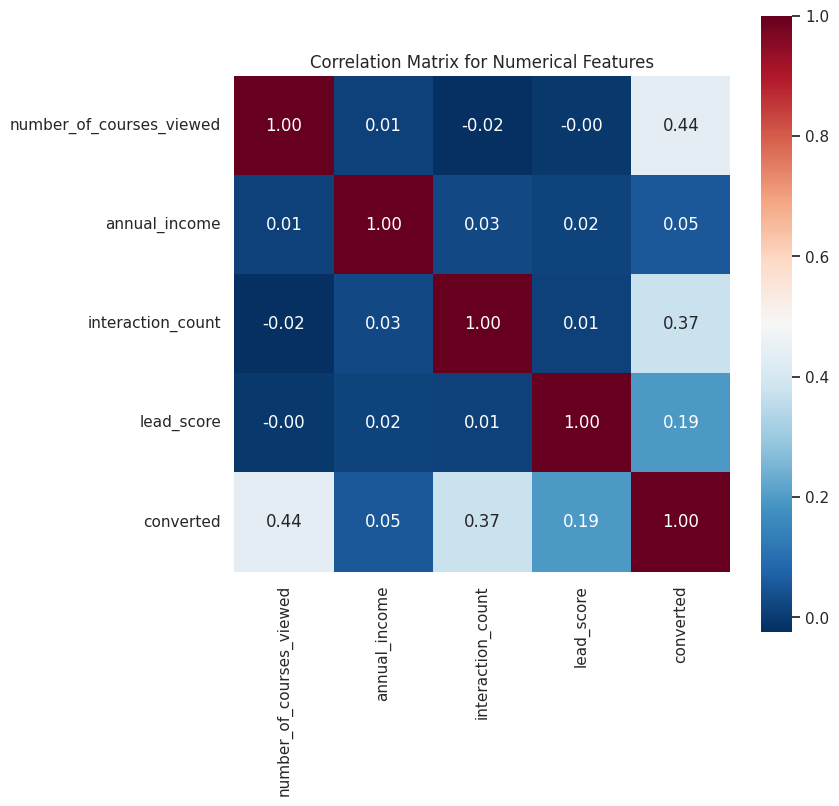

In [52]:
# # Create interactive Plotly heatmap
# fig = px.imshow(
#     corr_matrix,
#     text_auto=".3f",
#     color_continuous_scale='RdBu_r',
#     title="Correlation Matrix for Numerical Features",
#     aspect="equal", 
# )

# fig.update_layout(
#     title_x=0.5,
#     title_font=dict(size=20),
#     xaxis_title="Features",
#     yaxis_title="Features",
#     width=1000, 
#     height=800
# )
# fig.show()

# fig.write_html("correlation_matrix.html")

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f', square=True)
plt.title('Correlation Matrix for Numerical Features')
plt.show()